## Author Name: Aditya Gogate


## Part 1 - Recommendation System

### Objective 
- The objective is to build a recommender system.
- Different types of recommender algorithms are used and evaluated to get the best outcome. 

In [1]:
from google.colab import drive
drive.mount('/content/drive')   

Mounted at /content/drive


In [2]:
!pip install implicit
import implicit
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
import scipy.sparse as sparse

     |████████████████████████████████| 1.1MB 32.2MB/s 
  Created wheel for implicit: filename=implicit-0.4.4-cp37-cp37m-linux_x86_64.whl size=3406390 sha256=12d6bcd09405ed41b4ba28920a17122abd3331a24904a684155d63d337bc5577
  Stored in directory: /root/.cache/pip/wheels/bf/d4/ec/fd4f622fcbefb7521f149905295b2c26adecb23af38aa28217
Successfully built implicit


In [3]:
from implicit.evaluation import precision_at_k

In [4]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet


import warnings; warnings.simplefilter('ignore')

### Reading data file and understanding it.

In [5]:
validation_data= pd. read_csv('/content/drive/MyDrive/res2021/flickr_validation_data.csv')
validation_data.head()

,user_id,item_id,rating
0,0,20,1
1,0,3260,0
2,0,390,0
3,0,5425,0
4,0,8631,0


In [6]:
train_data= pd. read_csv('/content/drive/MyDrive/res2021/flickr_train_data.csv')
train_data.head()

,user_id,item_id,rating
0,0,0,1
1,0,1,1
2,0,2,1
3,0,3,1
4,0,4,1


In [7]:
test_data= pd. read_csv('/content/drive/MyDrive/res2021/flickr_test_data.csv')
test_data.head()

,user_id,item_id
0,0,8929
1,0,8906
2,0,8838
3,0,8821
4,0,8756


In [8]:
validation_data['rating'].value_counts()

0    343134
1      3466
Name: rating, dtype: int64

In [56]:
train_data['rating'].value_counts()

1    110129
Name: rating, dtype: int64

### Creating New training dataset

In [9]:
new_training_data = pd.concat([train_data, validation_data], ignore_index=True)
print(len(new_training_data))
new_training_data = new_training_data.drop_duplicates()
print(len(new_training_data))
new_training_data.head()

456729
454846


,user_id,item_id,rating
0,0,0,1
1,0,1,1
2,0,2,1
3,0,3,1
4,0,4,1


In [10]:

num_users = len(new_training_data.user_id.unique())
num_items = len(new_training_data.item_id.unique())
print('Number of User - '+ str(num_users)+ '\nNumber of items - '+ str(num_items))

Number of User - 3466
Number of items - 9004


In [11]:
sparse_item_user = sparse.csr_matrix((new_training_data['rating'].astype(float), (new_training_data['item_id'], new_training_data['user_id'])))
sparse_user_item = sparse.csr_matrix((new_training_data['rating'].astype(float), (new_training_data['user_id'], new_training_data['item_id'])))

In [15]:
def recomm_data_builder(model):

    top15__recom_dict = {}

    for i in list(new_training_data.user_id.unique()):
        #getting the list of item id for each user from test data
        test_item_id = list(test_data[test_data.user_id==i].item_id)

        item_list = []
        #finding the top recommendations for each user
        recom_list = model.recommend(i,sparse_user_item, num_items)

        #for items in each user
        for items in recom_list:
            if items[0] in test_item_id:
                item_list.append(items)
            top15__recom_dict[i]  = item_list[:15]

    #For each user the top ten items are sorted out based on the above item lists
    top15__recom_dict_new = {}
    for j, user_ratings in top15__recom_dict.items():
        top15__recom_dict_new[j] = [iid for (iid, _) in user_ratings]

    return top15__recom_dict_new

### Algorithms

For recommoendations based on the Implicit feedback method we have different models like **Alternating Least Squares, Logistic Matrix Factorisation and Bayesian Personalised Ranking** that an be used to evaluate and recommend. 



#### ALS - Alternating Least Squares

ALS algo with the default parameter settings has following scores for after submission to Kaggle (NDCG score)
- ALS - 0.1586


To increase the performance of the ALS model different combination of parameter values were used. The best 5 models with best combinations are shown below

In [16]:
from implicit.evaluation import train_test_split
from implicit.evaluation import precision_at_k, mean_average_precision_at_k , train_test_split


def model_tester_als(fac,reg_val,iter,rs):
  #splting the data
  train, test = train_test_split(sparse_item_user*20, train_percentage=0.8)
  model_als = implicit.als.AlternatingLeastSquares(factors=fac, regularization=reg_val,iterations=iter,use_gpu = True,random_state = rs)
  #fitting the data
  model_als.fit(train)
  train, test = train.T.tocsr(), test.T.tocsr()
  #fetching score
  pres = precision_at_k(model_als, train_user_items=train, test_user_items=test,K=10, num_threads=4)
  avg = mean_average_precision_at_k(model_als, train, test, K=15)

  return(pres,avg)



In [17]:
#passing the top 5 parameter combination to above precission score function
top_5_dict_pres = {}
top_5_dict_avg = {}
pres , avg = model_tester_als(9,2.0,300,10)
top_5_dict_pres["model-1"] =   [pres]
top_5_dict_avg["model-1"] =   [avg]
pres , avg = model_tester_als(32,0.50,400,10)
top_5_dict_pres["model-2"] =   [pres]
top_5_dict_avg["model-2"] =   [avg]
pres , avg = model_tester_als(32,1.5,250,10)
top_5_dict_pres["model-3"] =   [pres]
top_5_dict_avg["model-3"] =   [avg]
pres , avg = model_tester_als(32,2.5,300,10)
top_5_dict_pres["model-4"] =   [pres]
top_5_dict_avg["model-4"] =   [avg]
pres , avg = model_tester_als(32,1.0,400,10)
top_5_dict_pres["model-5"] =   [pres]
top_5_dict_avg["model-5"] =   [avg]

top_5_dict_pres
top_5_dict_avg
#print('precision - '+ str(pres)+ '\n avg  - '+ str(avg))

GPU training requires factor size to be a multiple of 32. Increasing factors from 9 to 32.


{'model-1': [0.004795422162412283],
 'model-2': [0.004413352410342659],
 'model-3': [0.004982615067099304],
 'model-4': [0.004459453888287139],
 'model-5': [0.0041433742932619495]}

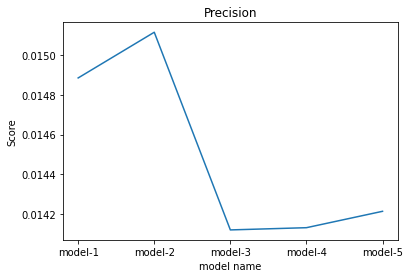

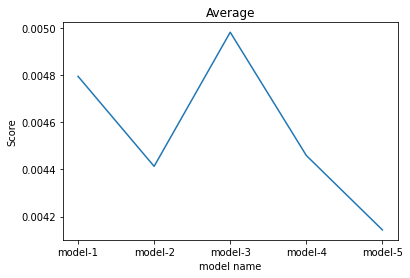

In [18]:
#visualizing the top 5 ALS models on the precision and mean score. 
import matplotlib.pylab as plt

lists = sorted(top_5_dict_pres.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.plot(x, y)
plt.xlabel("model name")
plt.ylabel("Score")
plt.title("Precision")
plt.show()

lists2 = sorted(top_5_dict_avg.items()) # sorted by key, return a list of tuples

x, y = zip(*lists2) # unpack a list of pairs into two tuples

plt.plot(x, y)
plt.xlabel("model name")
plt.ylabel("Score")
plt.title("Average")
plt.show()

##### Observation for ALS top-5 models 
After building the model we can clearly see model-3 parameters are performing the best amoung the cases. 

When we uploaded the output of the model on kaggle we got a score of 
0.19729 which is acceptable. 
This was the best score using ALS. 

##### best model build for ALS 

In [19]:
#Preparing data based on Alpha
data_mod = (sparse_item_user*10).astype('double')

#defining and fitting the model 32,0.50,400,10
model_als = implicit.als.AlternatingLeastSquares(factors=9, regularization=0.10,iterations=300,use_gpu = True,random_state = 7)
#model = implicit.als.AlternatingLeastSquares(factors=15,iterations=500)
model_als.fit(data_mod)

#Finding the top 10 recommendations
final_dict = recomm_data_builder(model_als)
#print(final_dict)
# #Storing results in data frame for exporting 
final_outcome_ALS = pd.melt(pd.DataFrame.from_dict(final_dict))
final_outcome_ALS.columns = ('user_id', 'item_id')
final_outcome_ALS.to_csv('output_als_31173799_v.4.9.csv',index=False) 

#### LMF - Logistic Matrix Factoriztion

LMF algo with the default parameter settings has following scores for after submission to Kaggle (NDCG score)
- LMF - 0.1682

To increase the performance of the LMF model different combination of parameter values were used. The best 5 models with best combinations are shown below


In [20]:
from implicit.evaluation import train_test_split
from implicit.evaluation import precision_at_k, mean_average_precision_at_k , train_test_split


def model_tester_lmf(fac,reg_val,iter,rs):

  train, test = train_test_split(sparse_item_user*20, train_percentage=0.8)
  model_als = implicit.lmf.LogisticMatrixFactorization(factors=fac, regularization=reg_val, iterations=iter,num_threads = 3 ,random_state = rs)
  model_als.fit(train)
  train, test = train.T.tocsr(), test.T.tocsr()
  pres = precision_at_k(model_als, train_user_items=train, test_user_items=test,K=10, num_threads=4)
  avg = mean_average_precision_at_k(model_als, train, test, K=15)

  return(pres,avg)


In [21]:
top_5_dict_pres = {}
top_5_dict_avg = {}
pres , avg = model_tester_lmf(9,2.0,300,10)
top_5_dict_pres["model-1"] =   [pres]
top_5_dict_avg["model-1"] =   [avg]
pres , avg = model_tester_lmf(32,0.50,400,10)
top_5_dict_pres["model-2"] =   [pres]
top_5_dict_avg["model-2"] =   [avg]
pres , avg = model_tester_lmf(32,1.5,250,10)
top_5_dict_pres["model-3"] =   [pres]
top_5_dict_avg["model-3"] =   [avg]
pres , avg = model_tester_lmf(9,2.0,300,8)
top_5_dict_pres["model-4"] =   [pres]
top_5_dict_avg["model-4"] =   [avg]
pres , avg = model_tester_lmf(32,1.0,400,10)
top_5_dict_pres["model-5"] =   [pres]
top_5_dict_avg["model-5"] =   [avg]

top_5_dict_pres
top_5_dict_avg

100%|██████████| 300/300 [00:12<00:00, 24.01it/s]


  0%|          | 1/400 [00:00<00:46,  8.67it/s]

100%|██████████| 400/400 [00:43<00:00,  9.24it/s]


  0%|          | 1/250 [00:00<00:28,  8.67it/s]

100%|██████████| 250/250 [00:26<00:00,  9.42it/s]


  1%|          | 2/300 [00:00<00:14, 19.89it/s]

100%|██████████| 300/300 [00:12<00:00, 24.29it/s]


  0%|          | 1/400 [00:00<00:44,  9.06it/s]

100%|██████████| 400/400 [00:42<00:00,  9.36it/s]


{'model-1': [0.0027814991034271095],
 'model-2': [0.0031837916305798492],
 'model-3': [0.003306742058012771],
 'model-4': [0.003186138240108176],
 'model-5': [0.0029526209068572173]}

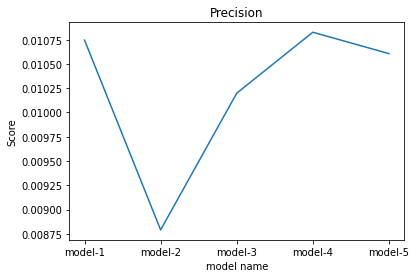

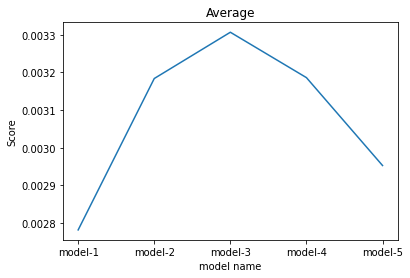

In [22]:
import matplotlib.pylab as plt

lists = sorted(top_5_dict_pres.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.plot(x, y)
plt.xlabel("model name")
plt.ylabel("Score")
plt.title("Precision")
plt.show()

lists2 = sorted(top_5_dict_avg.items()) # sorted by key, return a list of tuples

x, y = zip(*lists2) # unpack a list of pairs into two tuples

plt.plot(x, y)
plt.xlabel("model name")
plt.ylabel("Score")
plt.title("Average")
plt.show()

As we can see frim above graph model 4 works the best among the rest. 
After running the model and uploading the results on kaggle we got an accuracy of 0.21128 as the best score amoung all the LMF models. 

The final model code is below. 

In [23]:
data_mod1 = (sparse_item_user*1).astype('double')
#learning_rate=0.93,
model_lmf = implicit.lmf.LogisticMatrixFactorization(factors=9,learning_rate= 0.93, regularization=2.0, iterations=300,num_threads = 3 ,random_state = 10)

#train the model on a sparse matrix of item/user/interactions
model_lmf.fit(data_mod1)

#Finding the top 15 recommendations
final_dict = recomm_data_builder(model_lmf)

#Exporting the results
final_outcome_LMF = pd.melt(pd.DataFrame.from_dict(final_dict))
final_outcome_LMF.columns = ('user_id', 'item_id')
final_outcome_LMF.to_csv('output_lmf_31173799_v.3.12.csv',index=False)

100%|██████████| 300/300 [00:14<00:00, 20.31it/s]


#### BPR - Bayesian Personalized Ranking

BPR algo with the default parameter settings has following scores for after submission to Kaggle (NDCG score)
- BPR - 0.13146

Even after changing parameters for BPR the best score achieved was 0.15
hence ALS and LMF clearly outperform in this case and those are the best choice. 

In [24]:
# #defining and fitting the model
# model_bpr = implicit.bpr.BayesianPersonalizedRanking()
# model_bpr.fit(sparse_item_user)

# #Finding the top 15 recommendations
# final_dict = recomm_data_builder(model_bpr)

# #Storing results in data frame for exporting 
# final_outcome_BPR = pd.melt(pd.DataFrame.from_dict(final_dict))
# final_outcome_BPR.columns = ('user_id', 'item_id')
# final_outcome_BPR.to_csv('output_bpr_31173799_v.2.csv',index=False)

### Result after Fine Tuning
- After iterating through multiple parameter values, the above models are built using the parameters of each models The two models built above scored a percentage of **0.197 for ALS**  and **0.21 for LMF**
- In this particular scenario LMF is performing slightly better than ALS Or we can say that LMF is better tuned than ALS.


### ------------------------------------------------------------------------------------------------------------------------------

## Part 2 - Node clustering

### objective 
The aim of the task is to perform node clustering with different clustering algorithms.
-At least one embedding approach
(text embedding or network embedding) should be used. You should justify the use of different
graph information as well as the recommended algorithm for this task

In [25]:
!pip install node2vec

  Created wheel for node2vec: filename=node2vec-0.4.3-cp37-none-any.whl size=5980 sha256=85a3b17f4a035ce5e0fddb2ad32c232515d16751e718c20705e153447b1648ae
  Stored in directory: /root/.cache/pip/wheels/34/f4/60/55708b5e797260310451d919c8f898bbd4acd1901367001f20
Successfully built node2vec


In [26]:
#Importing necessary libraries
import networkx as nx
import pandas as pd

#!pip install node2vec
from node2vec import Node2Vec

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [27]:
import nltk
from sklearn.pipeline import Pipeline
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
import re
from nltk.stem  import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import cluster
from sklearn import metrics
from sklearn.metrics.cluster import normalized_mutual_info_score as nmis


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


### Reading data file and understanding it.

In [30]:
#Collecting the node ID and content
data_docs = pd.read_csv('/content/drive/MyDrive/A2 graph data/docs.txt',sep = "\t",header= None , names = ["nodes"])
data_docs[["nodes","title"]] = data_docs["nodes"].str.split(" ",1,expand = True)
data_docs.head()


,nodes,title
0,12828558,"Assessing Local Institutional Capacity, Data A..."
1,66779408,THE PROSPECTS FOR INTERNET TELEPHONY IN EUROPE...
2,38902949,"Economic Shocks, Safety Nets, and Fiscal Const..."
3,33450563,"Reform, Growth, and Poverty in Vietnam"
4,57470294,Households and Economic Growth in Latin Americ...


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [55]:
#label file read 
label_data = pd.read_csv('/content/drive/MyDrive/A2 graph data/labels.txt',sep = " ",header= None , names = ["nodes","class"])
label_data.head()


,nodes,class
0,12828558,0
1,66779408,0
2,38902949,0
3,33450563,0
4,57470294,0


In [54]:
#Creating the empty graph
#grph = nx.Graph()

# Adding the nodes and edges to the graph
grph = nx.read_adjlist('/content/drive/MyDrive/A2 graph data/adjedges.txt')

tot_node = list(grph.nodes())

node_lbls = data_docs['nodes'].to_list()

nodes_not_needed = list(set(tot_node).difference(node_lbls))

grph.remove_nodes_from(nodes_not_needed)



# Converting it to undirected graph
#grph = grph.to_undirected()

In [33]:
#printing the number of nodes and edges in the graph
print('Number of edges:', grph.number_of_edges())
print('Number of nodes:', grph.number_of_nodes())

Number of edges: 9618
Number of nodes: 18720


### Plotting the network graphs. 

If we try to look properly we can see the edges although the graph is a bit overcrowded due to the size of data.

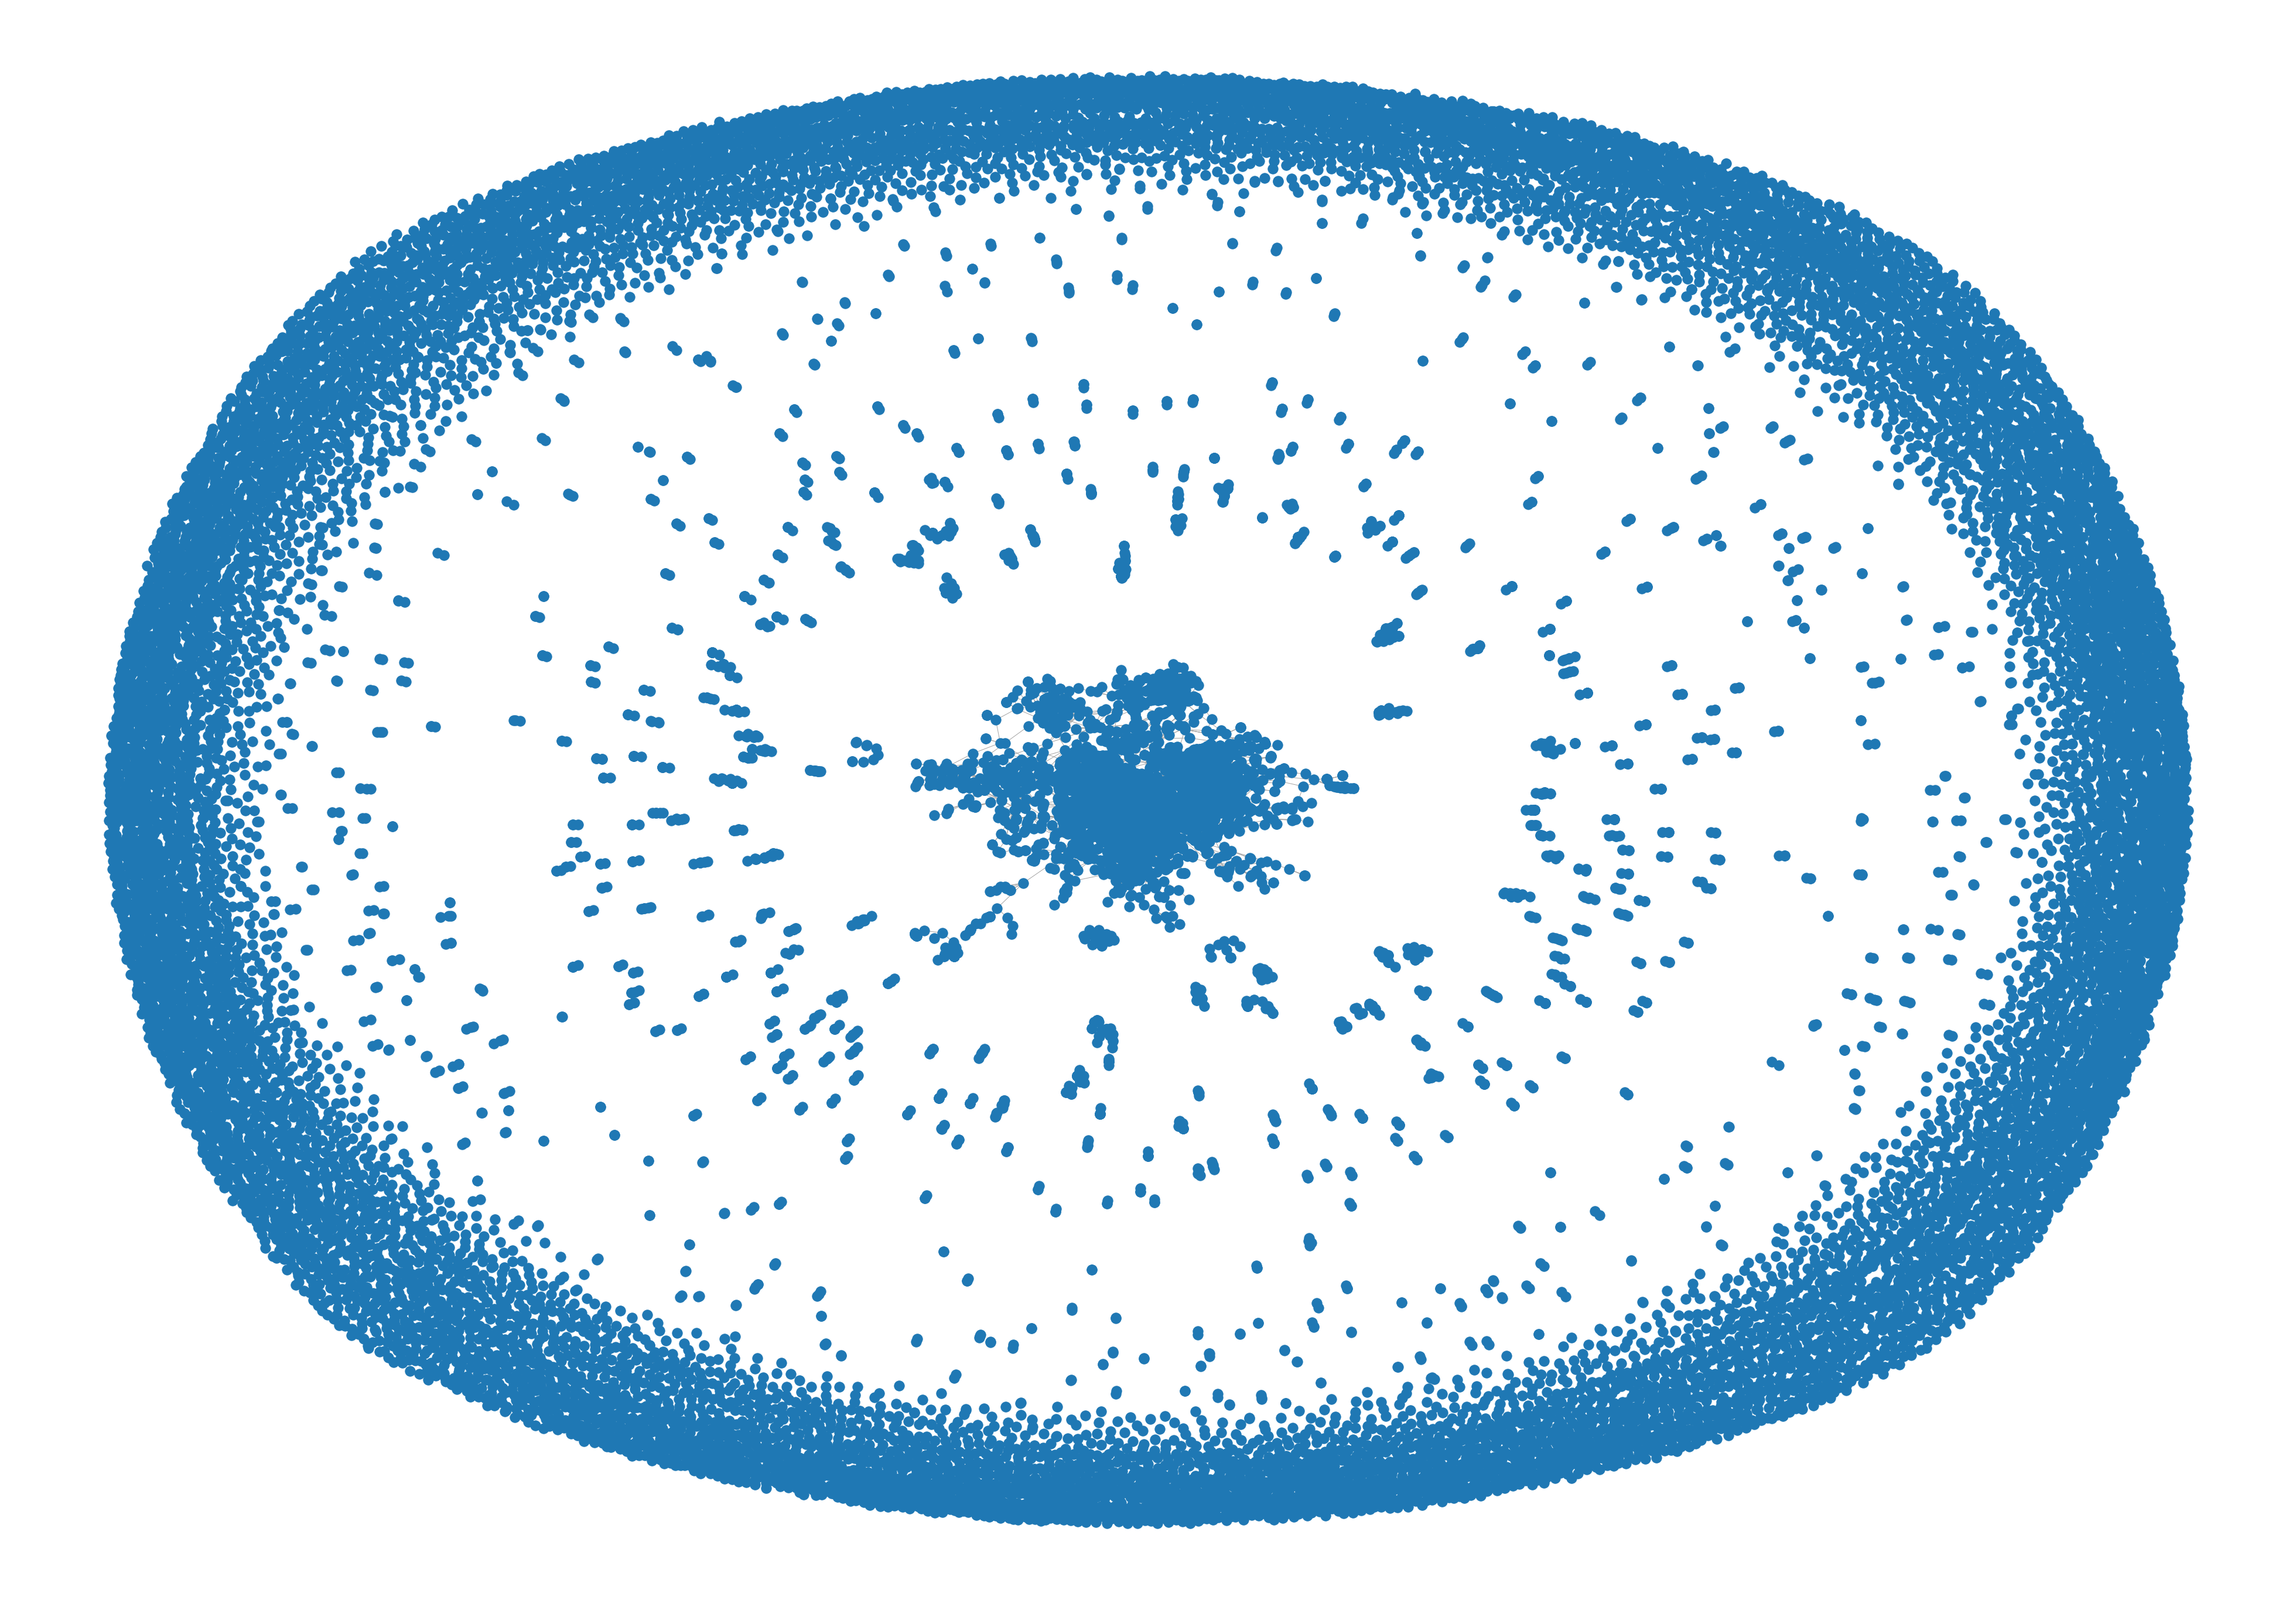

In [34]:
with sns.axes_style('white'):
    fig = plt.subplots(1, figsize=(70,50))
    nx.draw_networkx(grph, edge_color='#a4a4a4', with_labels=False, font_color='#cacaca')
    plt.axis('off')

### Node to vec K-means 

In [35]:
node2vec = Node2Vec(grph, dimensions=64, walk_length=20, num_walks=100)

Generating walks (CPU: 1):   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 100/100 [07:32<00:00,  4.53s/it]


In [36]:
model = node2vec.fit(window=10, min_count=1, batch_words=4)

In [37]:
vec_mod = model.wv.vectors

In [38]:
kmeans = cluster.KMeans(init = 'k-means++',n_clusters=5,n_init = 100)
kmeans.fit(vec_mod)
labels = kmeans.labels_

 

In [39]:
tr_lbl = label_data['class'].to_list()

In [40]:
#nmis(tr_lbl,labels,average_method='arithmetic')
print('normalized mutual info score:', round(nmis(tr_lbl,labels,average_method='arithmetic'),2))

normalized mutual info score: 0.45


### Node to vec with AgglomerativeClustering

In [41]:
alg = cluster.AgglomerativeClustering(n_clusters=5,affinity='euclidean',linkage='ward')
alg.fit(vec_mod)
labels = alg.labels_

In [42]:
#nmis(tr_lbl,labels,average_method='arithmetic')
print('normalized mutual info score:', round(nmis(tr_lbl,labels,average_method='arithmetic'),2))

normalized mutual info score: 0.44


### Spectral with K-means

In [43]:
spec_l = nx.laplacian_matrix(grph).astype(float)

In [44]:
!pip install scipy
import scipy as sp

In [45]:
w,v = sp.sparse.linalg.eigsh(spec_l,k = 4 , which = 'SM')

In [46]:
print(w.shape,v.shape)
X = v*w

(4,) (18720, 4)


In [47]:
kmeans = cluster.KMeans(init = 'k-means++',n_clusters=5,n_init = 151)
kmeans.fit(X)
labels = kmeans.labels_


In [48]:
#nmis(tr_lbl,labels,average_method='arithmetic')
print('normalized mutual info score:', round(nmis(tr_lbl,labels,average_method='arithmetic'),2))

normalized mutual info score: 0.03


### Text Embedding

In [49]:
def preprocess_model_steps(txt):
  txt = txt.lower()
  
  txt = re.sub(r"(?:\@|http?\://|https?\://|www)\S+"," ",txt)
  
  txt = re.sub(r"\s+"," ",txt)
 
  txt = re.sub(r"\d+"," ",txt)

  #txt = data_frame.apply(lambda data : nltk.word_tokenize(data))

  #data_frame = data_frame.apply(lambda data : token for token in data if not token.isnumeric)

  tkns = [lemmatizer.lemmatize(tk) for tk in nltk.word_tokenize(txt) if len(tk)>1]
 
  return tkns

In [50]:
#stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [51]:
vectorizer = TfidfVectorizer(tokenizer=preprocess_model_steps,stop_words={'english'})
doc_vectorized = vectorizer.fit_transform(data_docs['title'])

In [52]:
model_kmeans = cluster.KMeans(init = 'k-means++',n_clusters=5,n_init = 151)
model_kmeans.fit_predict(doc_vectorized)
labels = model_kmeans.labels_

In [53]:
nmis(tr_lbl,labels,average_method='arithmetic')

print('normalized mutual info score:', round(nmis(tr_lbl,labels,average_method='arithmetic'),2))

normalized mutual info score: 0.11


Reference – 
https://www.mygreatlearning.com/blog/
introduction-to-spectral-clustering/
https://implicit.readthedocs.io/en/latest/lmf.html
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
https://scikit-learn.org/stable/modules/clustering.html#affinity-propagation
https://realpython.com/k-means-clustering-python/
Lecture notes and Tutorial files


